In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
import math
from sklearn.preprocessing import MinMaxScaler

In [20]:
import os
os.chdir('../../')

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [4]:
real_data = pd.read_excel('./documents/nov_nine_var.xlsx').to_numpy()
goal_data = pd.read_excel('./documents/result/basic_formula.xlsx').to_numpy()

scaler = MinMaxScaler()
scaler = scaler.fit(real_data[:,1:22])

In [5]:
def load_data(data, i):
    data = scaler.transform(data[:,1:22])[i].reshape(1, 21)

    return np.round(data, 2)

def argmax(l):
    return max(range(len(l)), key=lambda i: l[i])

def argmin(l):
    return min(range(len(l)), key=lambda i: l[i])

In [6]:
start = load_data(real_data, -1)
goal = load_data(goal_data, argmin(goal_data[:,-1]))

print(goal[0])
print(start[0])

need_step = int(np.sum(abs(goal-start))*100)
print(need_step)

[0.51 0.5  0.5  0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.5
 0.5  0.5  0.49 0.49 0.51 0.5  0.5 ]
[0.   0.98 0.   1.   0.99 1.   0.   0.78 0.09 0.46 0.4  0.58 0.27 0.32
 0.23 0.23 1.   0.03 0.5  0.43 1.  ]
689


In [7]:
# actor-critic hyperparmater
GAMMA = 0.99
EPISODE_DONE = need_step * 10
EPS = np.finfo(np.float32).eps.item()
ACTION_NUM = 42

In [8]:
def return_action(i):
    a = np.zeros((1, 21))
    j = i // 2

    if i % 2 == 0:
        a[0][j] = -0.01
    
    else:
        a[0][j] = 0.01
    
    return a

In [9]:
def return_state(s, a):
    ns = s + a
    return ns

In [10]:
def return_reward(ns, gs):
    dist = np.sqrt(np.sum(np.square(gs - ns)))

    end = 0
    for i in range(21):
        if ns[0][i] == gs[0][i]:
            end += 5
    
    reward = -dist + end
    return reward

In [11]:
class Actor_Critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_layer = tf.keras.models.Sequential()
        self.input_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.input_layer.add(tf.keras.layers.Dense(128, activation='relu'))

        self.actor_layer = tf.keras.models.Sequential()
        self.actor_layer.add(tf.keras.layers.Dense(ACTION_NUM, activation='softmax'))

        self.critic_layer = tf.keras.models.Sequential()
        self.critic_layer.add(tf.keras.layers.Dense(1, activation='linear'))

    def call(self, x):
        i = self.input_layer(x)

        a = self.actor_layer(i)
        c = self.critic_layer(i)

        return a, c

In [18]:
class AC_agent:
    def __init__(self):
        self.model = Actor_Critic()
        self.optim = tf.keras.optimizers.Adam(learning_rate=1e-10)

        self.huber_loss = tf.keras.losses.Huber()

    def expected_q(self, rewards):
        discounted_sum = 0
        returns = np.zeros_like(rewards)
        for i, r in enumerate(rewards):
            discounted_sum = r + GAMMA * discounted_sum
            returns[i] = discounted_sum
        returns = (returns - np.mean(returns)) / (np.std(returns) + EPS)

        return returns.tolist()

    def act(self, state):
        action_prob, value = self.model(state)
        action = np.random.choice(ACTION_NUM, p=np.squeeze(action_prob))

        return action, action_prob, value

    def run(self, state, rewards, steps):
        returns = self.expected_q(rewards)

        states = tf.convert_to_tensor(state).reshape(steps-1, 21)
        returns = tf.convert_to_tensor(returns)

        loss = self.learn(states, returns)
        return loss

    @tf.function
    def learn(self, s, r):
        with tf.GradientTape() as tape:
            p, v = self.model(s)
            adv = r - v[0]
            log_p = tf.math.log(p)

            actor_loss = -tf.math.reduce_sum(log_p * adv)

            critic_loss = self.huber_loss(v, r)

            loss = actor_loss + critic_loss
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

In [19]:
agent = AC_agent()
state_hist = []
reward_hist = [[] for i in range(4)]
loss_hist = []
steps_list = []

for e in range(10000):
    counter = [0 for i in range(42)]
    state = start
    steps = 1
    reward = return_reward(state, goal)

    done = 0
    rewards = 0
    min_reward = 100
    max_reward = -100

    state_history = []
    reward_history = []

    while True:
        # model_state = np.array([state, goal]).reshape(1, 42)
        model_state = state
        a_i, a_p, c_v = agent.act(model_state)
        action = return_action(a_i)
        counter[a_i] += 1

        next_state = return_state(state, action)
        reward = return_reward(next_state, goal)
        # print(f'steps: {steps}, reward: {reward}, loss: {loss}')

        state = next_state
        rewards += reward
        steps += 1

        if steps == EPISODE_DONE or all(state[0] == goal[0]):
            done = 1

        if reward < min_reward:
            min_reward = reward

        if reward > max_reward:
            max_reward = reward

        steps_list.append(reward)
        state_hist.append(state)

        state_history.append(model_state)
        reward_history.append(reward)

        if done:
            loss = agent.run(state_history, reward_history, steps)

            rewards = rewards if steps - 1 == EPISODE_DONE else 0
            reward_hist[0].append(rewards)
            reward_hist[1].append(rewards/steps)
            reward_hist[2].append(max_reward)
            reward_hist[3].append(min_reward)
            loss_hist.append(loss)
            steps_list.append(0 if steps == EPISODE_DONE else 1)

            print(f'{e if steps -1 == EPISODE_DONE else 0}: {round(min_reward, 1)}, {round(max_reward, 1)}, {round(reward, 1)}')
            print(f"mean rewards: {round(rewards/steps, 3)}, net_loss: {round(loss, 3)}, most action: {argmax(counter)}|{max(counter)}/{steps}")
            print(state[0])

            break

ValueError: in user code:

    File "C:\Users\dlkan\AppData\Local\Temp\ipykernel_12896\1249415675.py", line 40, in learn  *
        print(tf.matmul(log_p, adv))

    ValueError: Dimensions must be equal, but are 42 and 6889 for '{{node MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](Log, sub)' with input shapes: [6889,42], [6889,6889].


In [ ]:
# [0.51 0.5  0.5  0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.5
#  0.5  0.5  0.49 0.49 0.51 0.5  0.5 ]
# [0.   0.98 0.   1.   0.99 1.   0.   0.78 0.09 0.46 0.4  0.58 0.27 0.32
#  0.23 0.23 1.   0.03 0.5  0.43 1.  ]

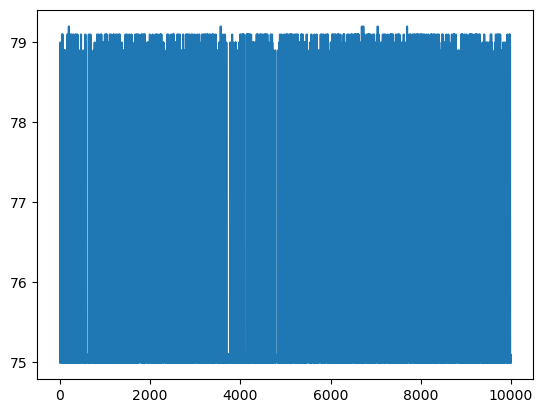

In [ ]:
plt.plot(reward_hist[2])
plt.show()

In [ ]:
for i, r in enumerate(reward_hist[2]):
    if r > 79:
        print(f'r: {r}, i: {i}')

r: 79.1, i: 48
r: 79.1, i: 54
r: 79.1, i: 167
r: 79.1, i: 179
r: 79.1, i: 188
r: 79.2, i: 196
r: 79.1, i: 209
r: 79.1, i: 210
r: 79.1, i: 227
r: 79.1, i: 258
r: 79.1, i: 293
r: 79.1, i: 342
r: 79.1, i: 357
r: 79.1, i: 388
r: 79.1, i: 466
r: 79.1, i: 563
r: 79.1, i: 638
r: 79.1, i: 676
r: 79.1, i: 823
r: 79.1, i: 854
r: 79.1, i: 906
r: 79.1, i: 916
r: 79.1, i: 995
r: 79.1, i: 1025
r: 79.1, i: 1031
r: 79.1, i: 1035
r: 79.1, i: 1104
r: 79.1, i: 1130
r: 79.1, i: 1184
r: 79.1, i: 1186
r: 79.1, i: 1188
r: 79.1, i: 1192
r: 79.1, i: 1238
r: 79.1, i: 1271
r: 79.1, i: 1305
r: 79.1, i: 1323
r: 79.1, i: 1453
r: 79.1, i: 1482
r: 79.1, i: 1538
r: 79.1, i: 1585
r: 79.1, i: 1666
r: 79.1, i: 1703
r: 79.1, i: 1710
r: 79.1, i: 1743
r: 79.1, i: 1807
r: 79.1, i: 1814
r: 79.1, i: 1849
r: 79.1, i: 1864
r: 79.1, i: 1878
r: 79.1, i: 1992
r: 79.1, i: 2052
r: 79.1, i: 2117
r: 79.1, i: 2136
r: 79.1, i: 2169
r: 79.1, i: 2222
r: 79.1, i: 2225
r: 79.1, i: 2227
r: 79.1, i: 2248
r: 79.1, i: 2378
r: 79.1, i: 2404
r: 79